In [23]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from ssim_psnr import get_psnr

def calculate_ssim(img1, img2):
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    ssim_value = 0
    for i in range(img1_np.shape[0]):  # 배치 크기 만큼 반복
        for j in range(img1_np.shape[1]):  # 채널 수 만큼 반복
            ssim_value += ssim(img1_np[i, j], img2_np[i, j], data_range=1.0)
    ssim_value /= (img1_np.shape[0] * img1_np.shape[1])
    return ssim_value

def calculate_psnr(img1, img2):
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    psnr_value = 0
    for i in range(img1_np.shape[0]):  # 배치 크기 만큼 반복
        for j in range(img1_np.shape[1]):  # 채널 수 만큼 반복
            psnr_value += psnr(img1_np[i, j], img2_np[i, j], data_range=1.0)
    psnr_value /= (img1_np.shape[0] * img1_np.shape[1])
    return psnr_value

def to_tensor(image_array):
    image_tensor = image_array.transpose(2, 0, 1)[None]
    return torch.tensor(image_tensor)

def read_image(image_path, size=128):
    image_obj = Image.open(image_path).resize((128, 128), 1)
    image_array = np.array(image_obj)
    return image_array

def get_score(image_array_source, image_array_target, target="skimage"):
    image_tensor_source = to_tensor(image_array_source)
    image_tensor_target = to_tensor(image_array_target)
    
    score = None
    if target == "skimage":
        score = calculate_psnr(image_tensor_source, image_tensor_target)
    else:
        score = get_psnr(image_tensor_source, image_tensor_target)
        
    return -score

# Run my custom ssim and the original ssim 100 times to check if they produce the same results in 1e-5

In [44]:
repeat_num = 100
for repeat_idx in tqdm(range(repeat_num)):
    test_tensor_1 = torch.rand((1, 4, 256, 256)).clip(0, 1)
    test_tensor_2 = torch.rand((1, 4, 256, 256)).clip(0, 1)

    numpy_pnsr_score = calculate_psnr(test_tensor_1, test_tensor_2)
    numpy_pnsr_score = torch.tensor(numpy_pnsr_score, dtype=torch.float32)
    torch_psnr_score = get_psnr(test_tensor_1, test_tensor_2, data_range=1.0)

    assert torch.allclose(numpy_pnsr_score, torch_psnr_score, atol=1e-5), f"trial {repeat_idx + 1} is failed"
print("test passed")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 155.42it/s]


# Check with Image

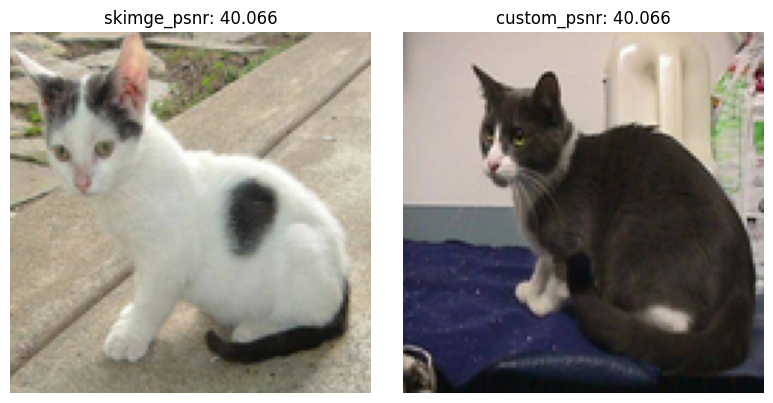

In [42]:
cat_image_path_1 = "./images/cat.3.jpg"
cat_image_path_2 = "./images/cat.4.jpg"

cat_array_1 = read_image(cat_image_path_1)
cat_array_2 = read_image(cat_image_path_2)

skimage_score = get_score(cat_array_1, cat_array_2, target="skimage")
torch_score = get_score(cat_array_1, cat_array_2, target="custom")

_, ax = plt.subplots(1, 2, figsize=(8, 4))
for ax_item in ax.flat:  # 모든 서브플롯에 대해
    ax_item.set_axis_off()  # 축 숨기기
    
ax[0].imshow(cat_array_1)
ax[1].imshow(cat_array_2)

ax[0].set_title(f"skimge_psnr: {skimage_score:.3f}")
ax[1].set_title(f"custom_psnr: {torch_score:.3f}")

plt.tight_layout()
plt.show()


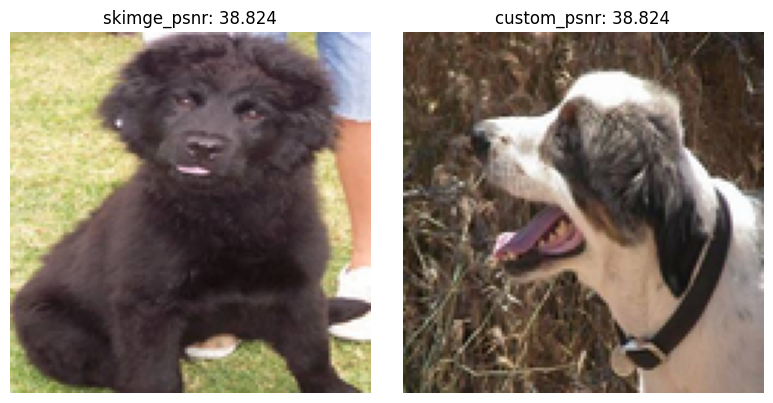

In [43]:
cat_image_path_1 = "./images/dog.118.jpg"
cat_image_path_2 = "./images/dog.122.jpg"

cat_array_1 = read_image(cat_image_path_1)
cat_array_2 = read_image(cat_image_path_2)

skimage_score = get_score(cat_array_1, cat_array_2, target="skimage")
torch_score = get_score(cat_array_1, cat_array_2, target="custom")

_, ax = plt.subplots(1, 2, figsize=(8, 4))
for ax_item in ax.flat:  # 모든 서브플롯에 대해
    ax_item.set_axis_off()  # 축 숨기기
    
ax[0].imshow(cat_array_1)
ax[1].imshow(cat_array_2)

ax[0].set_title(f"skimge_psnr: {skimage_score:.3f}")
ax[1].set_title(f"custom_psnr: {torch_score:.3f}")

plt.tight_layout()
plt.show()
